# Curso de Manejo de Datos Faltantes: Imputación

[![Curso creado por jvelezmagic](https://img.shields.io/badge/Desarrollado%20por-%40jvelezmagic-blue?&style=for-the-badge&logo=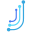)](https://jvelezmagic.com/)

![Curso de Manejo de Datos Faltantes: Exploración](course-logo.jpg)

## Configuración de ambiente de trabajo

```bash
pip install --upgrade pip
```

```bash
pip install pyjanitor matplotlib missingno nhanes pandas scipy seaborn session-info sklearn statsmodels upsetplot
```

or 

```bash
pip install -r requirements.txt
```

## Importar librerías

In [72]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

## Importar funciones personalizadas

In [73]:
%run pandas-missing-extension.ipynb

## Configurar el aspecto general de las gráficas del proyecto

In [74]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (8, 6)
    }
)

sns.set_style("whitegrid")

## El problema de trabajar con valores faltantes

In [75]:
airquality_df = (
    sm.datasets.get_rdataset("airquality")
    .data
    .clean_names(
        case_type = "snake"
    )
    .add_column("year", 1973)
    .assign(
        date = lambda df: pd.to_datetime(df[["year", "month", "day"]])
    )
    .sort_values(by = "date")
    .set_index("date")
)

airquality_df

/home/esteb/miniconda3/envs/missing_values_exploration/lib/python3.9/site-packages/pandas_flavor/register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.assign` instead.
  return method(self._obj, *args, **kwargs)


,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


### Reto: Datos de supervivientes

In [76]:
survival_df = sm.datasets.get_rdataset("flchain", "survival").data

Ajusta algunos modelos utilizando a las variables con valores faltantes como predictoras. ¿Qué sucede?

In [77]:
# Aquí tu código...

## Preparando datos: _National Health and Nutrition Examination Survey_

/home/esteb/miniconda3/envs/missing_values_exploration/lib/python3.9/site-packages/pandas_flavor/register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
/home/esteb/miniconda3/envs/missing_values_exploration/lib/python3.9/site-packages/pandas_flavor/register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


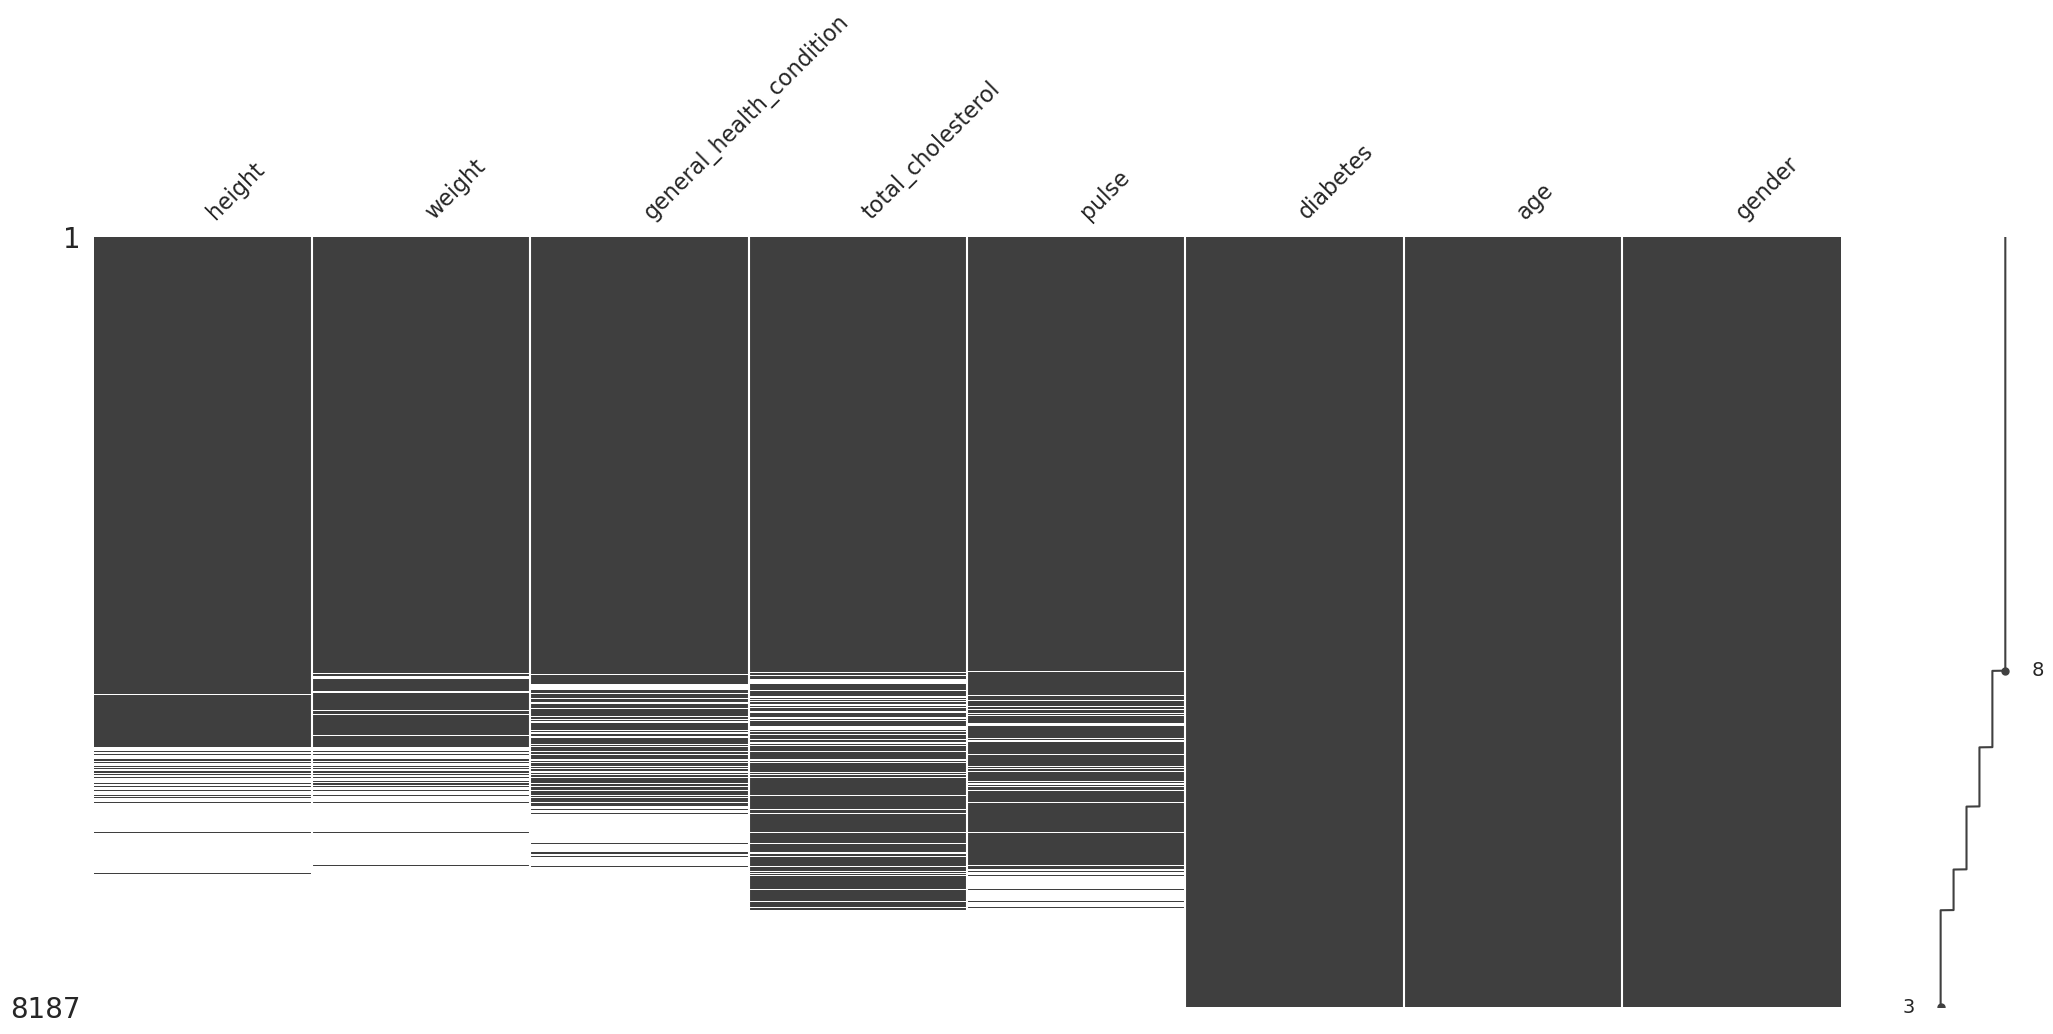

/home/esteb/miniconda3/envs/missing_values_exploration/lib/python3.9/site-packages/upsetplot/plotting.py:781: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/esteb/miniconda3/envs/missing_values_exploration/lib/python3.9/site-packages/upsetplot/plotting.py:782: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the inte

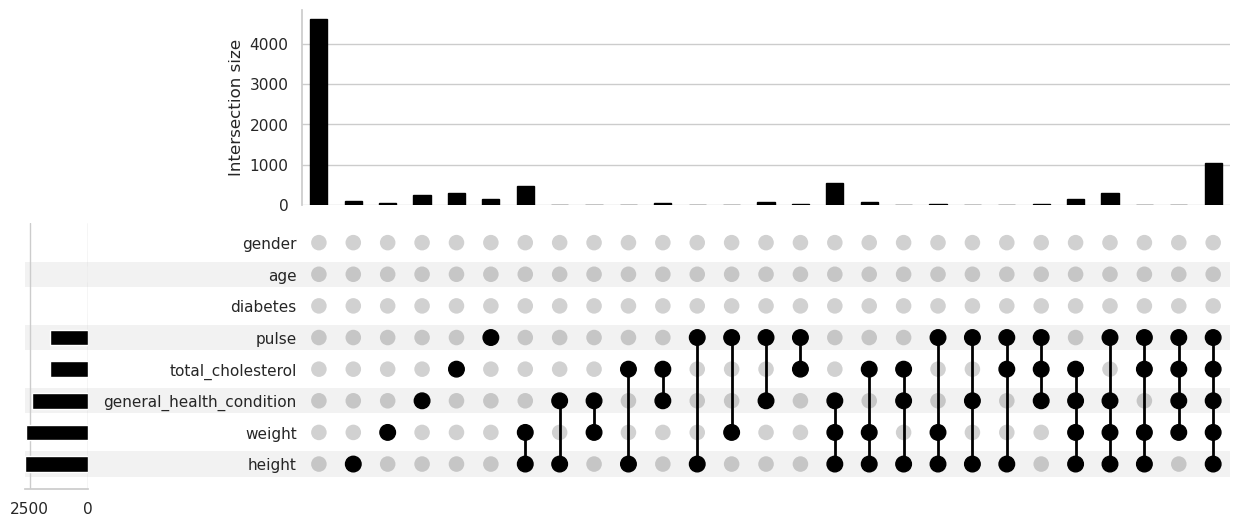

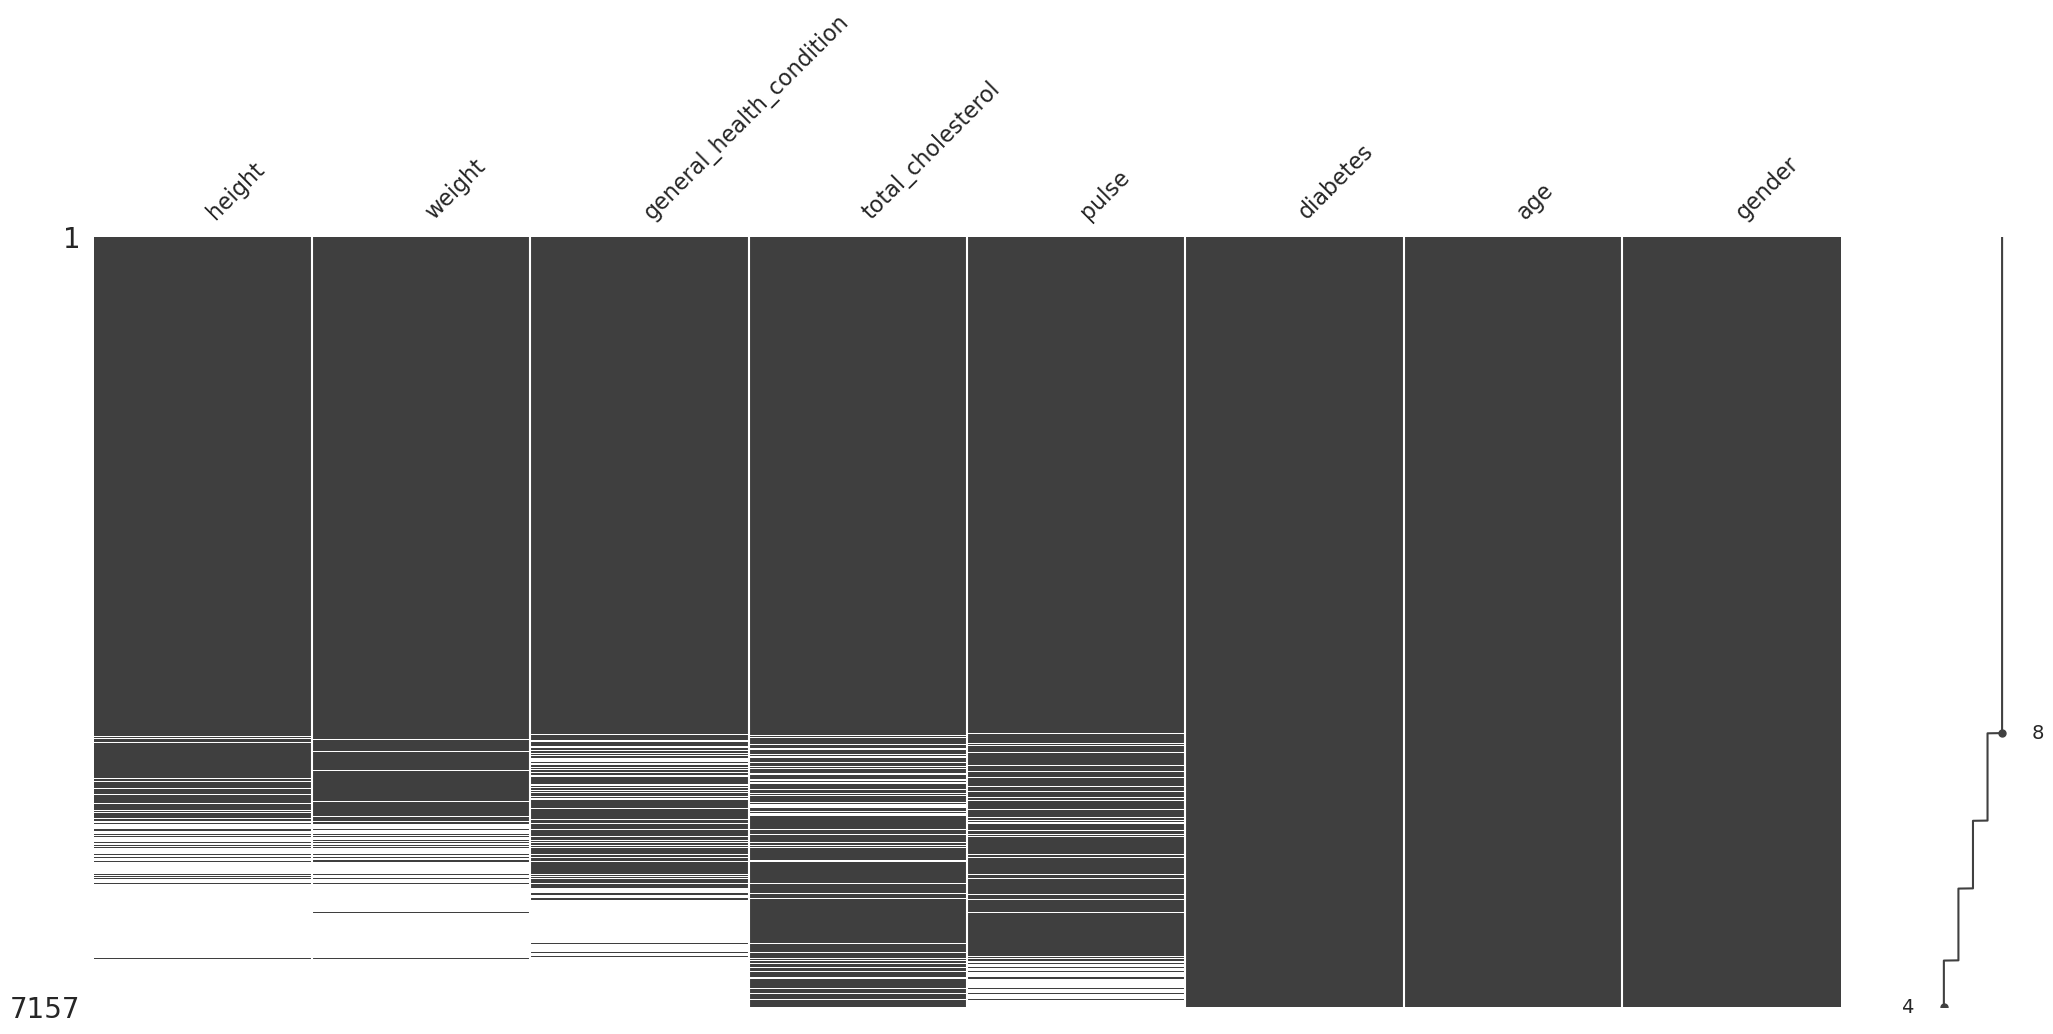

In [78]:
%run download-data-and-load-it.ipynb

## Consideración y evaluación de los distintos tipos de valores faltantes

![](missing_data_action.jpeg)

## Evaluación del mecanismo de valores faltantes por prueba de _t-test_

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <p>
<code>two-sided</code>: las <b>medias</b> de las distribuciones subyacentes a las muestras son <b>desiguales</b>.<br>
<code>less</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>menor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.<br>
<code>greater</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>mayor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.<br>
    </p>
</div>

In [79]:
female_weight, male_weight = (
    nhanes_df # type: ignore
    .select_columns('gender', 'weight')
    .transform_column(
        "weight",
        lambda x : x.isna(),
        elementwise = False
    )
    .groupby("gender")
    .weight
    .pipe(
        lambda df : (
            df.get_group("Female"),
            df.get_group('Male')
        )
    )
)
scipy.stats.ttest_ind(
    a = female_weight,
    b = male_weight,
    alternative = 'two-sided'
)

/home/esteb/miniconda3/envs/missing_values_exploration/lib/python3.9/site-packages/pandas_flavor/register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


TtestResult(statistic=-0.3621032192538131, pvalue=0.7172855918077239, df=7155.0)

## Amplía tu conjunto de herramientas para explorar valores faltantes

/home/esteb/miniconda3/envs/missing_values_exploration/lib/python3.9/site-packages/pandas_flavor/register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


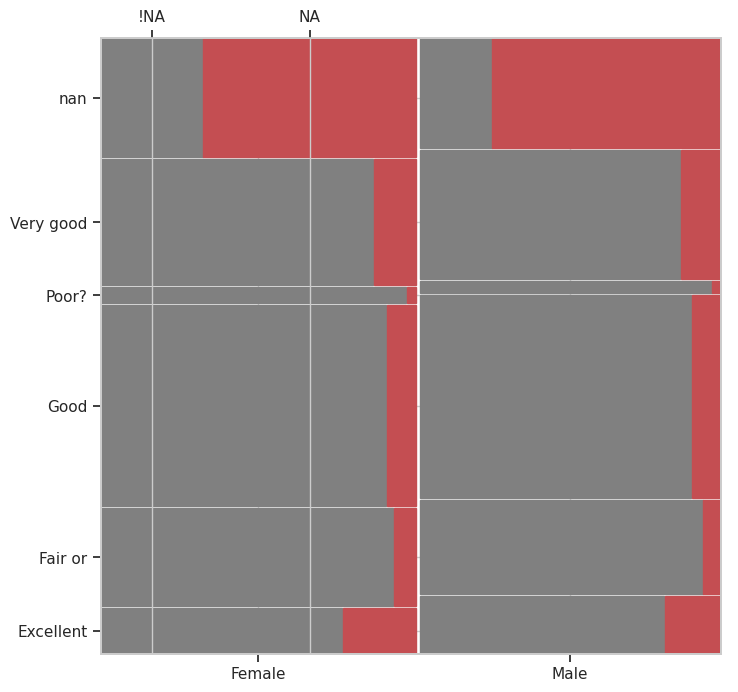

In [80]:
fig, ax = plt.subplots(figsize = (8, 8))
(
    nhanes_df
    .select_columns('weight', 'general_health_condition', 'gender')
    .assign(
        weight = lambda df : df.weight.isna().replace([True, False], ['NA', "!NA"])
    )
    .groupby(
        ["gender", 'general_health_condition', 'weight'],
        dropna = False,
        as_index = True
    )
    .size()
    .pipe(
        lambda df : mosaic(
            data = df,
            properties = lambda key : {'color' : 'r' if 'NA' in key else 'gray'},
            horizontal=True,
            axes_label=True,
            title='',
            labelizer= lambda key: '',
            ax = ax
        )
    )
);

## Tratamiento de variables categóricas para imputación de valores faltantes

In [81]:
nhanes_transformed_df = nhanes_df.copy(deep = True)

### Codificación ordinal

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <p>
    Una codificación ordinal <b>implica</b> mapear cada etiqueta (categoría) única a un valor entero. A su vez, la codificación ordinal también es conocida como codificación entera.
    </p>
</div>

#### Ejemplo

Dado un conjunto de datos con dos características, encontraremos los valores únicos por cataracterística y los transformaremos utilizando una codificación ordinal.

In [82]:
encoder = sklearn.preprocessing.OrdinalEncoder()

X = [['Male'], ['Female'],['Female']]
X

[['Male'], ['Female'], ['Female']]

In [83]:
encoder.fit_transform(X)

array([[1.],
       [0.],
       [0.]])

In [84]:
encoder.categories_

[array(['Female', 'Male'], dtype=object)]

In [85]:
encoder.inverse_transform([[1],[0],[0]])

array([['Male'],
       ['Female'],
       ['Female']], dtype=object)

#### Aplicando la codificación ordinal a todas tus variables categóricas

In [86]:
categorical_columns = nhanes_transformed_df.select_dtypes(include=[object,'category']).columns

In [87]:
categorical_transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    remainder="passthrough"
)

In [88]:
nhanes_transformed_df = pd.DataFrame(
    categorical_transformer.fit_transform(nhanes_df),
    columns=categorical_transformer.get_feature_names_out(),
    index=nhanes_df.index
             ).rename_columns(
                 function = lambda x : x.removeprefix('ordinalencoder__')
             ).rename_columns(
                 function = lambda x : x.removeprefix('remainder__')
             )
nhanes_transformed_df

/home/esteb/miniconda3/envs/missing_values_exploration/lib/python3.9/site-packages/pandas_flavor/register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,NaN,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


### _One Hot Encoding_

In [89]:
nhanes_transformed_df2 = nhanes_df.copy(deep=True)

### `pandas.get_dummies()` vs `skelearn.preprocessing.OneHotEncoder()`

#### `pandas.get_dummies()`

In [90]:
(
    nhanes_transformed_df2
    .select('general_health_condition')
    .pipe(pd.get_dummies)
)

,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good
SEQN,,,,,
93705.0,False,False,True,False,False
93706.0,False,False,False,False,True
93707.0,False,False,True,False,False
93709.0,False,False,False,False,False
93711.0,False,False,False,False,True
...,...,...,...,...,...
102949.0,True,False,False,False,False
102953.0,False,True,False,False,False
102954.0,False,False,True,False,False


#### `skelearn.preprocessing.OneHotEncoder()`

In [91]:
transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), ['gender']),
    (sklearn.preprocessing.OneHotEncoder(), ["general_health_condition"]),
    remainder="passthrough"
)

In [92]:
nhanes_transformed_df2 = (
    pd.DataFrame(
        transformer.fit_transform(nhanes_df),
        columns=transformer.get_feature_names_out(),
        index=nhanes_df.index
    )
    .rename_columns(
        function = lambda x : x.removeprefix('ordinalencoder__')
    )
    .rename_columns(
        function = lambda x : x.removeprefix('remainder__')
    )
    .rename_columns(
        function = lambda x : x.removeprefix('onehotencoder__')
    )
)
nhanes_transformed_df2

/home/esteb/miniconda3/envs/missing_values_exploration/lib/python3.9/site-packages/pandas_flavor/register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,gender,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good,general_health_condition_nan,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,,,,,,
93705.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102949.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


In [93]:
(
    transformer
    .named_transformers_
    .get('onehotencoder')
    .inverse_transform(
        X = [[0, 0, 1 , 0, 0 ,0]]
    )
)

array([['Good']], dtype=object)

## Tipos de imputación de valores faltantes

![](imputation_methods.png)

## Imputación de un único valor (media, mediana, moda)

In [94]:
(
    nhanes_df
    .transform_column(
        'height',
        lambda x : x.fillna(x.mean()),
        elementwise = False
    )
    .height
    .mean()
)

66.25655976676386

<AxesSubplot:xlabel='height', ylabel='weight'>

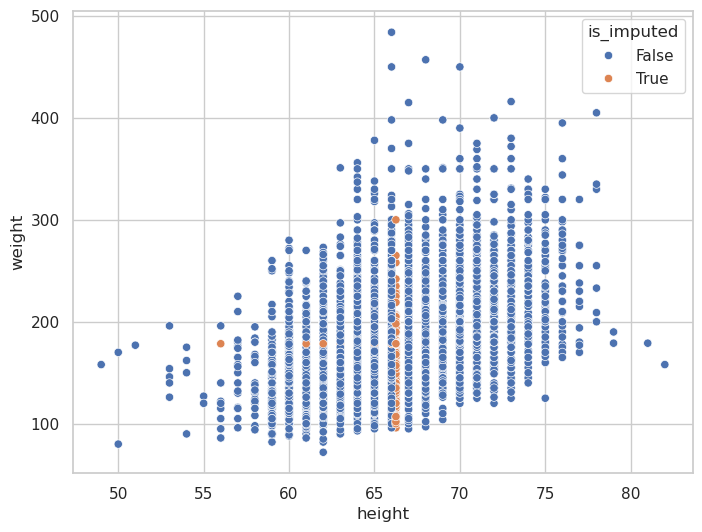

In [97]:
(
    nhanes_df
    .select('height', 'weight')
    .missing.bind_shadow_matrix(True, False, suffix = '_imp')
    .assign(
        height = lambda df : df.height.fillna(value = df.height.mean()),
        weight = lambda df : df.weight.fillna(value = df.weight.mean())
    )
    .missing.scatter_imputation_plot(
        x = 'height',
        y = 'weight'
    )
)

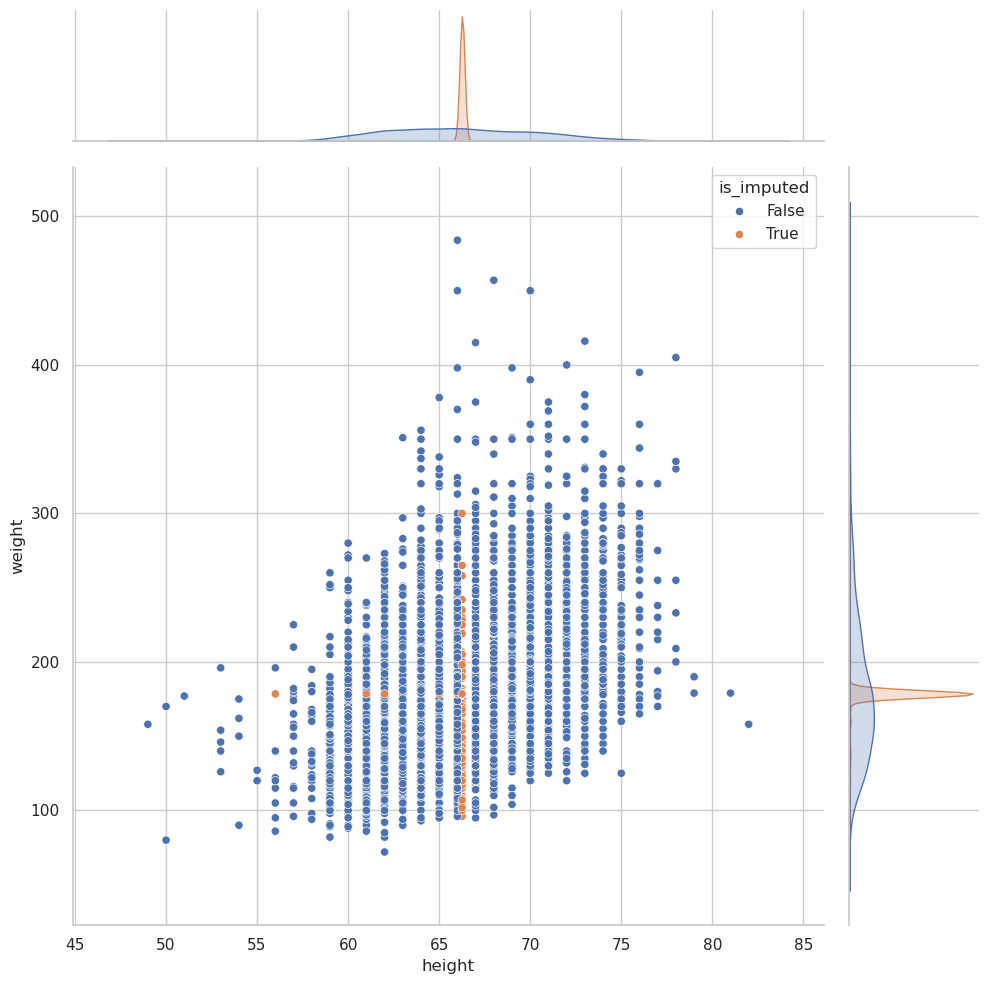

In [98]:
(
    nhanes_df
    .select('height', 'weight')
    .missing.bind_shadow_matrix(True, False, suffix = '_imp')
    .assign(
        height = lambda df : df.height.fillna(value = df.height.mean()),
        weight = lambda df : df.weight.fillna(value = df.weight.mean())
    )
    .missing.scatter_imputation_plot(
        x = 'height',
        y = 'weight',
        show_marginal = True,
        height = 10
    )
)

## Imputación por llenado hacia atrás e imputación por llenado hacia adelante

### `fillna()` vs `ffill()` o `bfill()`

In [100]:
(
    nhanes_df
    .select("height", "weight")
    .ffill()
)

,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,68.0,145.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


In [101]:
(
    nhanes_df
    .select("height", "weight")
    .bfill()
)

,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,62.0,200.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


#### Recomendaciones al imputar valores utilizando `ffill()` o `bfill()`

> Imputación dentro de dominios e imputación a través de variables correlacionadas

In [106]:
(
    nhanes_df
    .select('height','weight', 'gender', 'diabetes', 'general_health_condition')
    .sort_values(
        by = ['gender', 'diabetes', 'general_health_condition', 'height'],
        ascending = True
    )
    .groupby(
        ['gender','general_health_condition'],
        dropna = False
    )
    .apply(lambda x : x.ffill())
)

/tmp/ipykernel_35810/2499176206.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .apply(lambda x : x.ffill())
/tmp/ipykernel_35810/2499176206.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nhanes_df


height  weight  gender  diabetes  \
gender general_health_condition SEQN                                        
Female Excellent                94421.0    56.0   115.0  Female         0   
                                94187.0    59.0   130.0  Female         0   
                                95289.0    59.0   162.0  Female         0   
                                97967.0    59.0   130.0  Female         0   
                                99125.0    59.0   105.0  Female         0   
...                                         ...     ...     ...       ...   
Male   NaN                      96561.0    74.0   290.0    Male         1   
                                96954.0    74.0   175.0    Male         1   
                                97267.0    74.0   175.0    Male         1   
                                97856.0    74.0   175.0    Male         1   
                                98317.0    74.0   175.0    Male         1   

                                        general_health_condition  
gender general_health_condition SEQN                              
Female Excellent                94421.0                Excellent  
                                94187.0                Excellent  
                                95289.0                Excellent  
                                97967.0                Excellent  
                                99125.0                Excellent  
...                                                          ...  
Male   NaN                      96561.0                      NaN  
                                96954.0                      NaN  
                                97267.0                      NaN  
                                97856.0                      NaN  
                                98317.0                      NaN  

[7157 rows x 5 columns]

## Imputación por interpolación

<AxesSubplot:xlabel='date'>

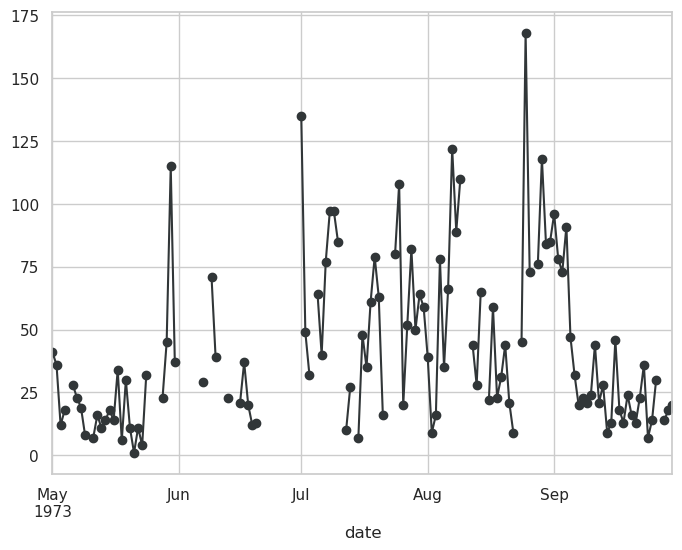

In [ ]:
(
    airquality_df
    .select('ozone')
    .pipe(
        lambda df : (
            df.ozone.plot(color = '#313638', marker = 'o')
        )
    )
)

(<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>)

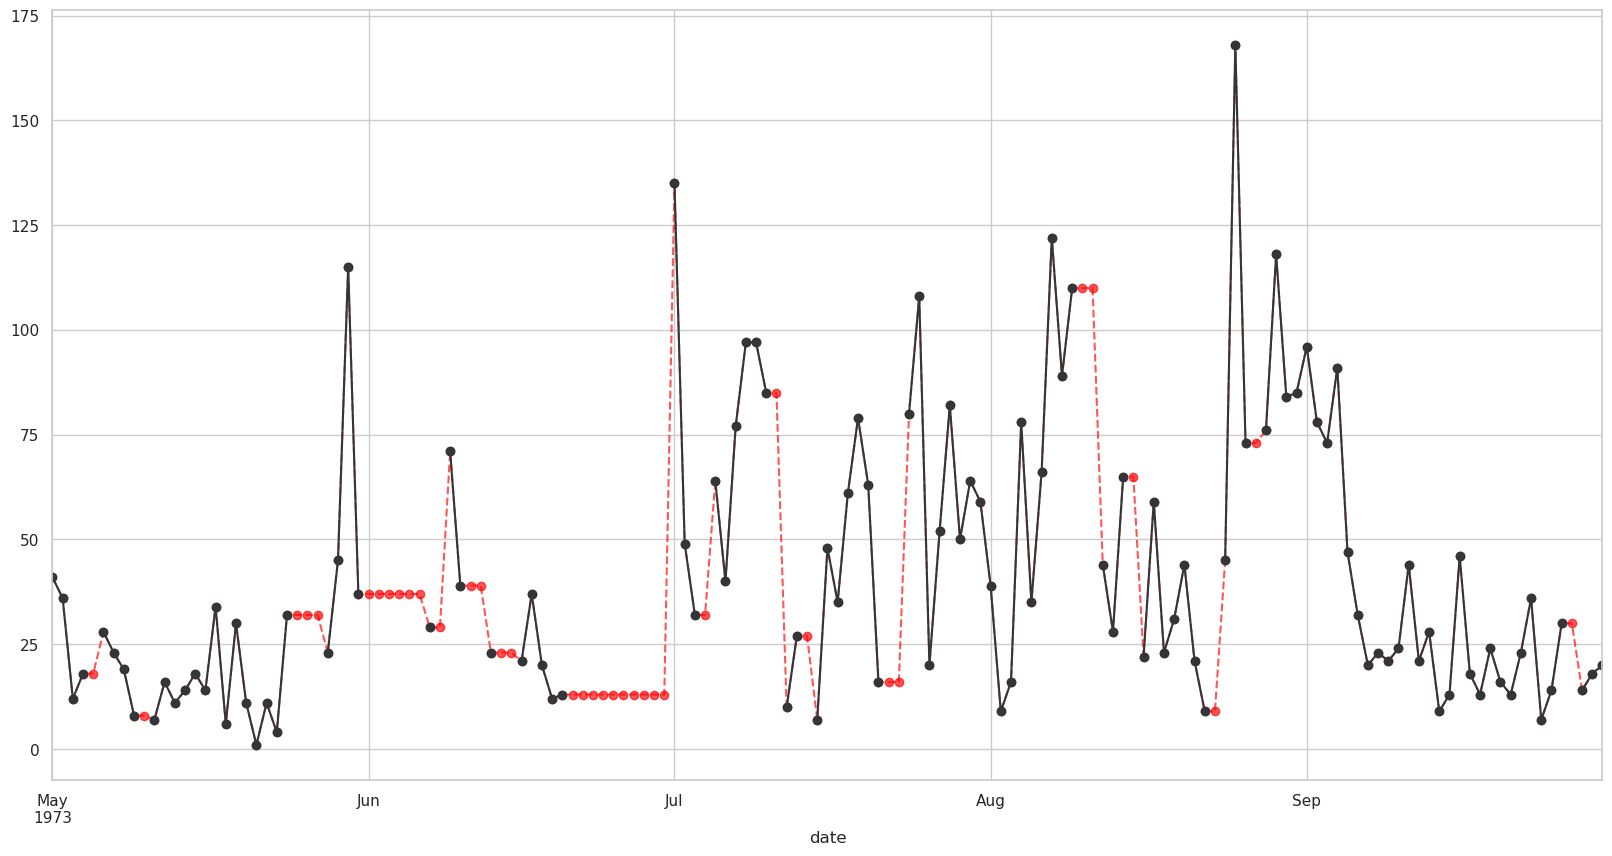

In [ ]:
plt.figure(figsize=(20, 10))

(
    airquality_df
    .select('ozone')
    .pipe(
        lambda df : (
            df.ozone.ffill().plot(color = 'red', marker = 'o', alpha = 6/9, linestyle = 'dashed'),
            df.ozone.plot(color = '#313638', marker = 'o')
        )
    )
)

(<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>)

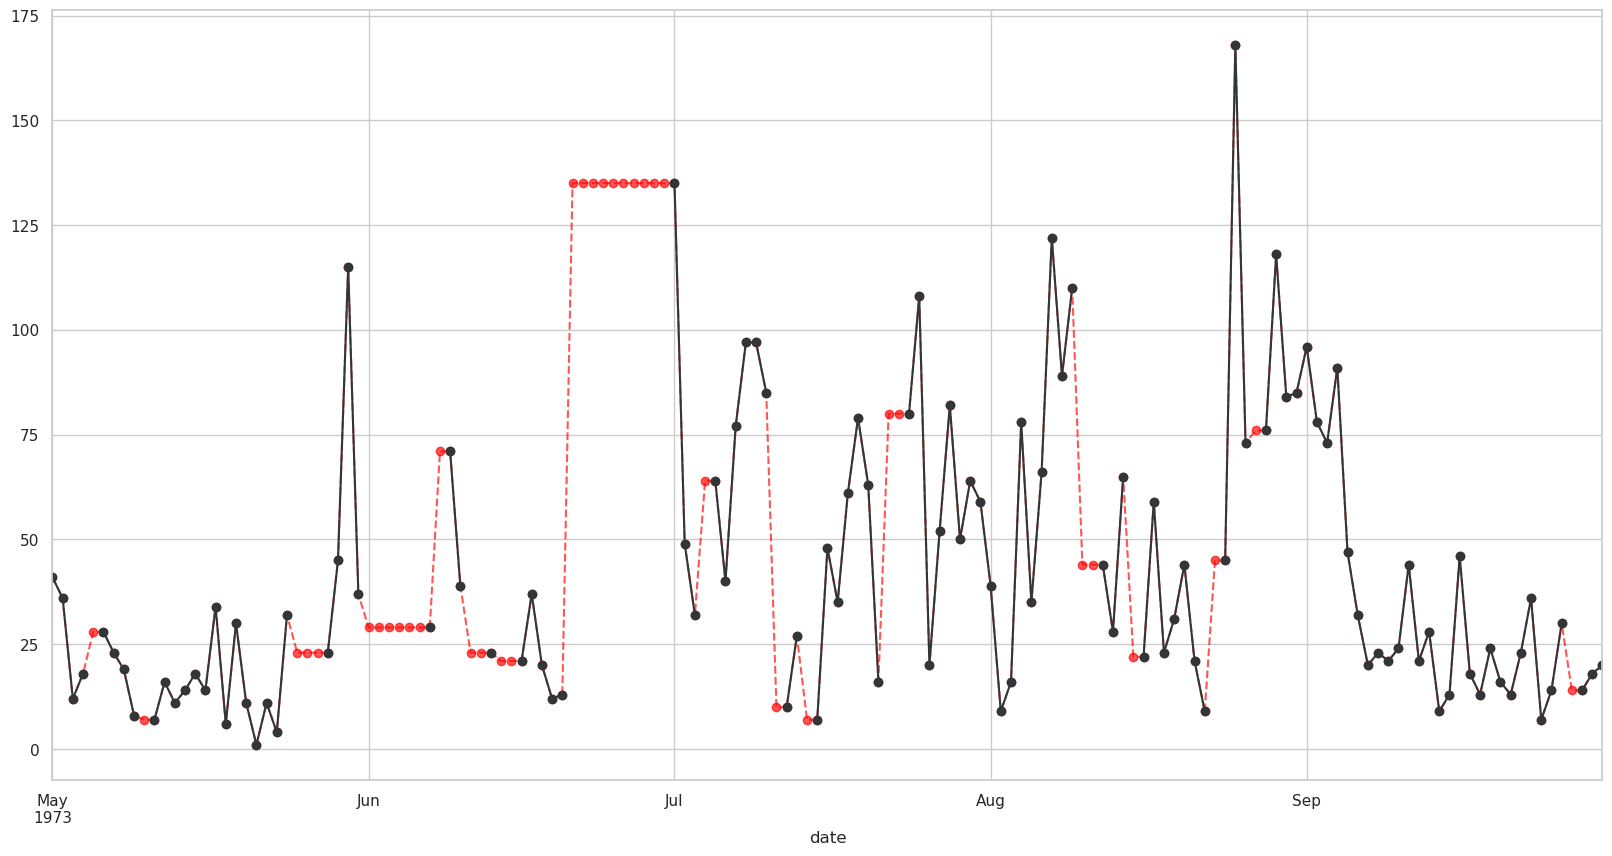

In [114]:
plt.figure(figsize=(20, 10))

(
    airquality_df
    .select('ozone')
    .pipe(
        lambda df : (
            df.ozone.bfill().plot(color = 'red', marker = 'o', alpha = 6/9, linestyle = 'dashed'),
            df.ozone.plot(color = '#313638', marker = 'o')
        )
    )
)

(<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>)

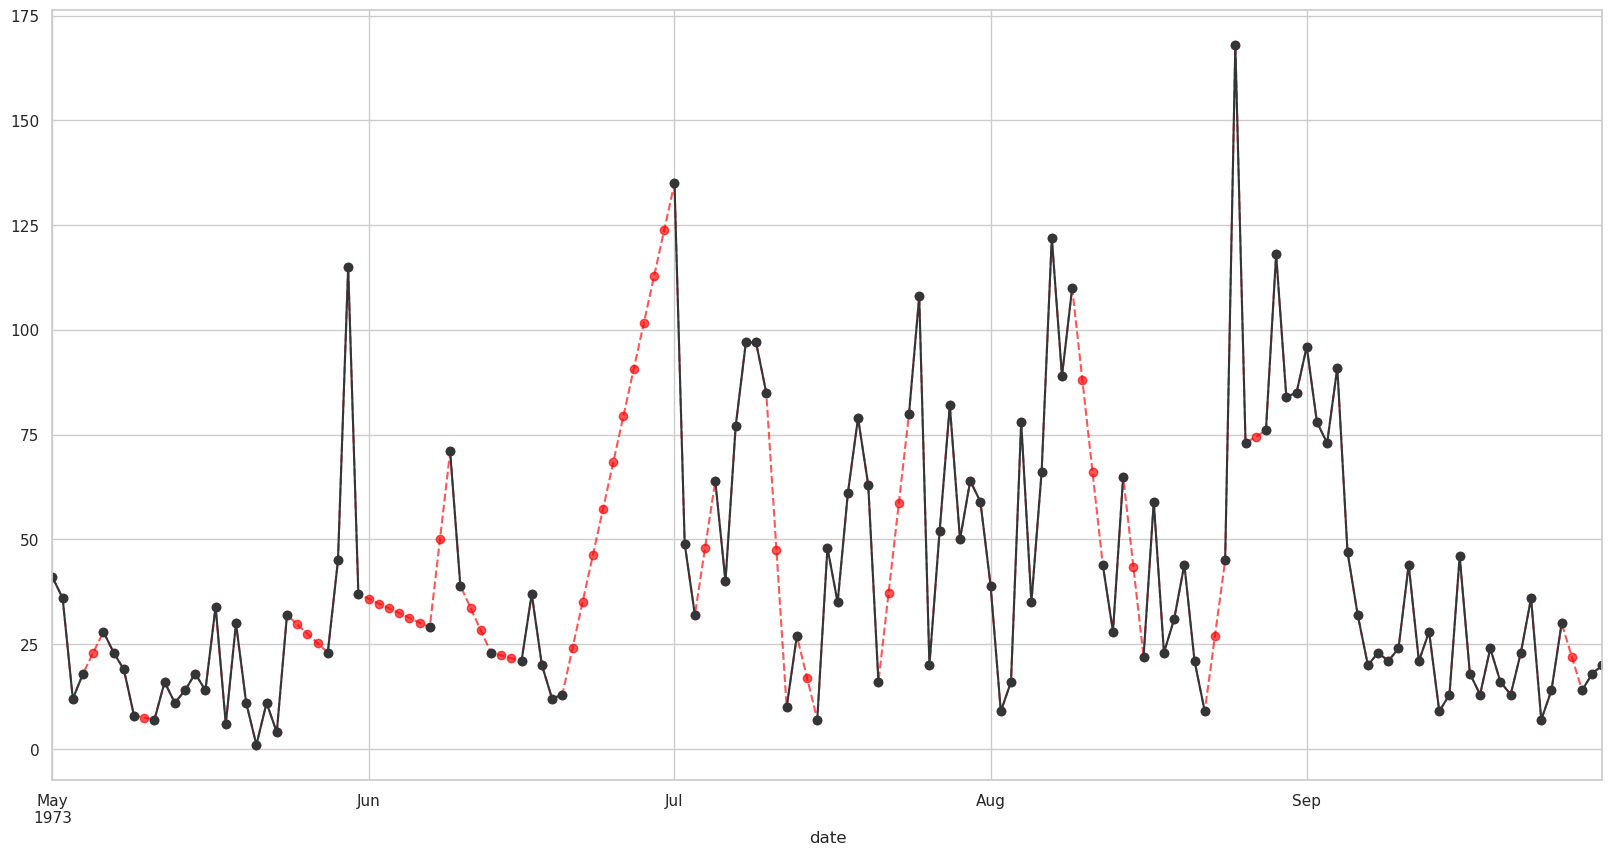

In [115]:
plt.figure(figsize=(20, 10))

(
    airquality_df
    .select('ozone')
    .pipe(
        lambda df : (
            df.ozone.interpolate(method = 'linear').plot(color = 'red', marker = 'o', alpha = 6/9, linestyle = 'dashed'),
            df.ozone.plot(color = '#313638', marker = 'o')
        )
    )
)

(<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>)

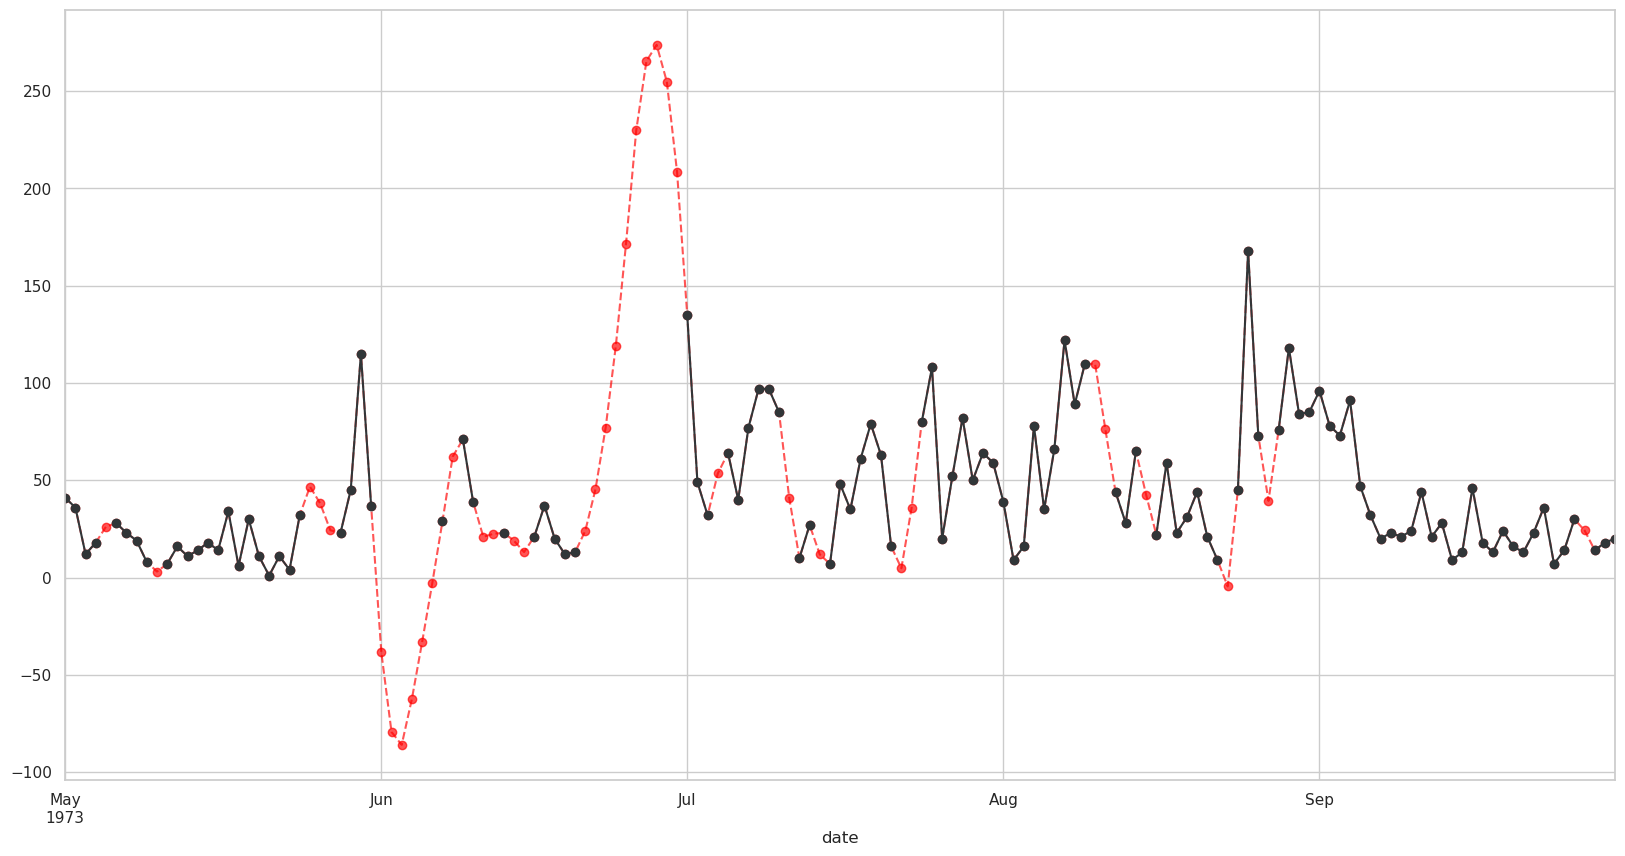

In [116]:
plt.figure(figsize=(20, 10))

(
    airquality_df
    .select('ozone')
    .pipe(
        lambda df : (
            df.ozone.interpolate(method = 'quadratic').plot(color = 'red', marker = 'o', alpha = 6/9, linestyle = 'dashed'),
            df.ozone.plot(color = '#313638', marker = 'o')
        )
    )
)

(<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>)

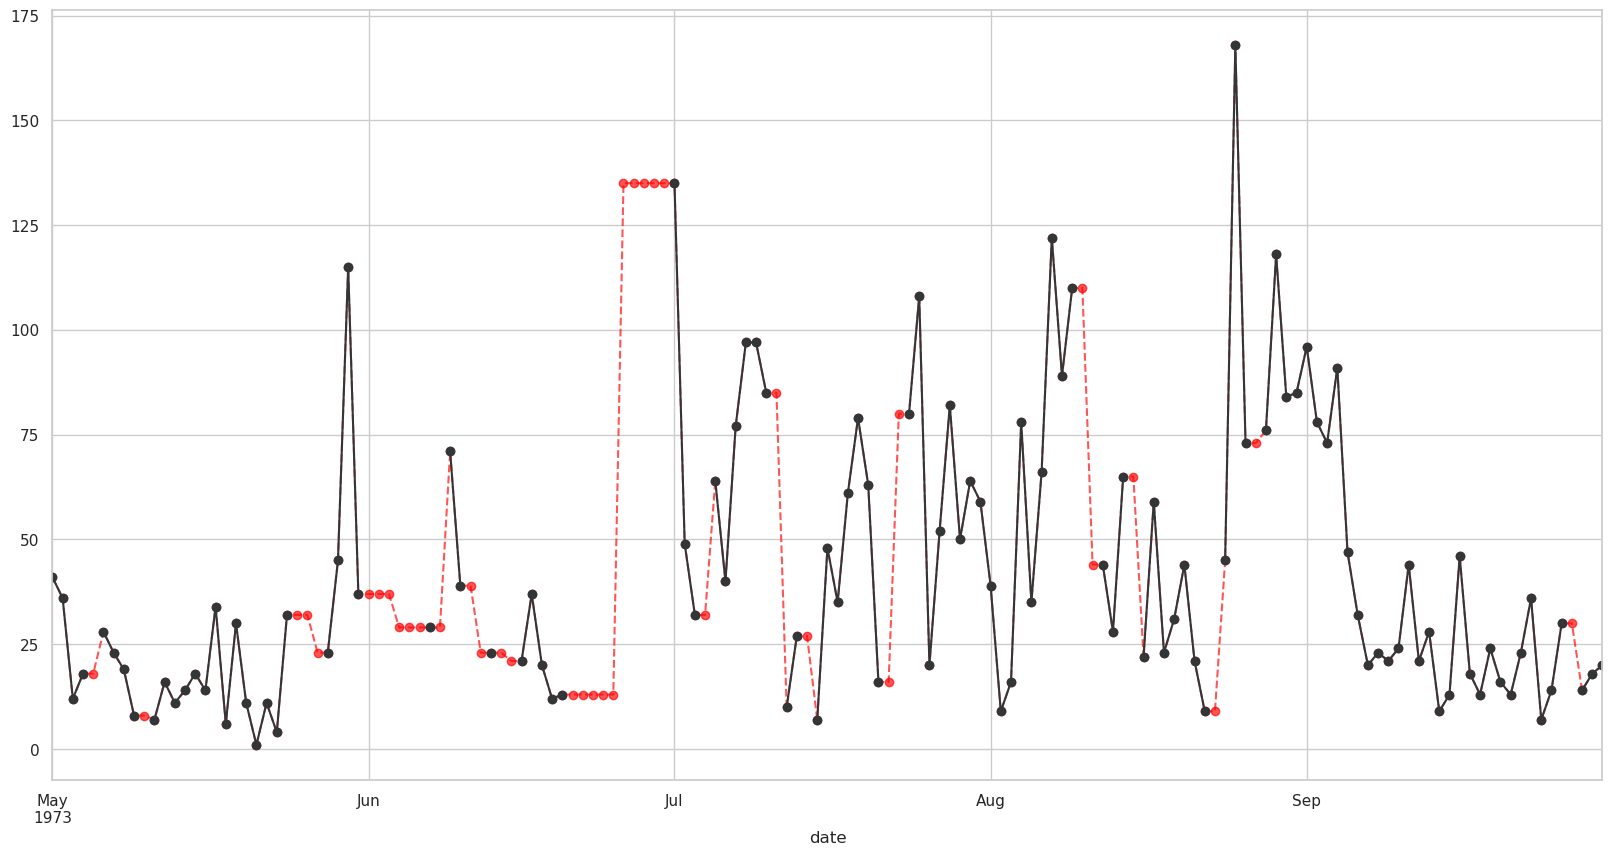

In [127]:
plt.figure(figsize=(20, 10))

(
    airquality_df
    .select('ozone')
    .pipe(
        lambda df : (
            df.ozone.interpolate(method = 'nearest').plot(color = 'red', marker = 'o', alpha = 6/9, linestyle = 'dashed'),
            df.ozone.plot(color = '#313638', marker = 'o')
        )
    )
)

In [128]:
airquality_df['ozone'] = airquality_df.ozone.interpolate(method='linear')

In [129]:
airquality_df

,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,23.0,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,22.0,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


## Imputación por algoritmo de vecinos más cercanos (KNN)

In [131]:
(
    nhanes_transformed_df
)

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,NaN,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


In [ ]:
knn_imputer = sklearn.impute.KNNImputer()

nhanes_df_knn = nhanes_transformed_df.copy(deep = True)

nhanes_df_knn.iloc[::] = knn_imputer.fit_transform(nhanes_transformed_df).round()
nhanes_df_knn

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,69.0,130.0,189.0,100.0,0.0,13.0
93709.0,2.0,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


<AxesSubplot:xlabel='height', ylabel='weight'>

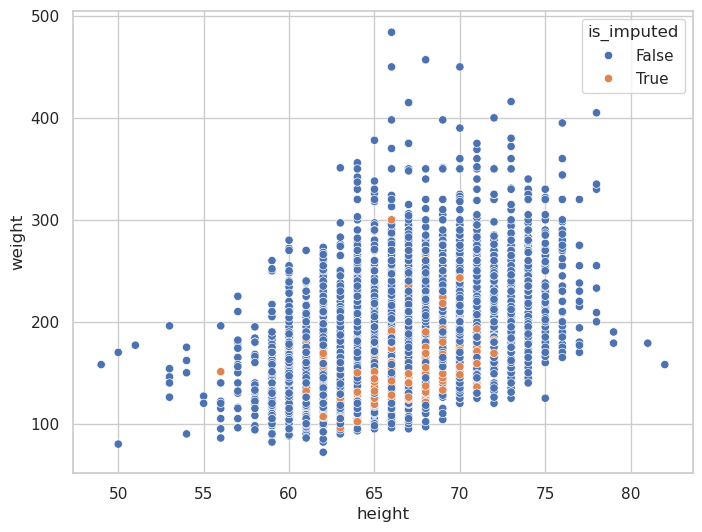

In [136]:
(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True, False, suffix='_imp', only_missing=True)
        ],
        axis = 1
    )
    .missing.scatter_imputation_plot(
        x="height",
        y='weight'
    )
)

### Ordenamiento por cantidad de variables faltantes

In [139]:
knn_imputer = sklearn.impute.KNNImputer()

nhanes_df_knn = nhanes_transformed_df.missing.sort_variables_by_missingness(ascending=True).copy(deep = True)

nhanes_df_knn.iloc[:, :] = knn_imputer.fit_transform(nhanes_transformed_df.missing.sort_variables_by_missingness(ascending=True)).round()
nhanes_df_knn

,gender,diabetes,age,pulse,total_cholesterol,general_health_condition,weight,height
SEQN,,,,,,,,
93705.0,0.0,0.0,66.0,52.0,157.0,2.0,165.0,63.0
93706.0,1.0,0.0,18.0,82.0,148.0,4.0,145.0,68.0
93707.0,1.0,0.0,13.0,100.0,189.0,2.0,130.0,69.0
93709.0,0.0,0.0,75.0,74.0,176.0,2.0,200.0,62.0
93711.0,1.0,0.0,56.0,62.0,238.0,4.0,142.0,69.0
...,...,...,...,...,...,...,...,...
102949.0,1.0,0.0,33.0,96.0,201.0,0.0,180.0,72.0
102953.0,1.0,0.0,42.0,78.0,182.0,1.0,218.0,65.0
102954.0,0.0,0.0,41.0,78.0,172.0,2.0,150.0,66.0


<AxesSubplot:xlabel='height', ylabel='weight'>

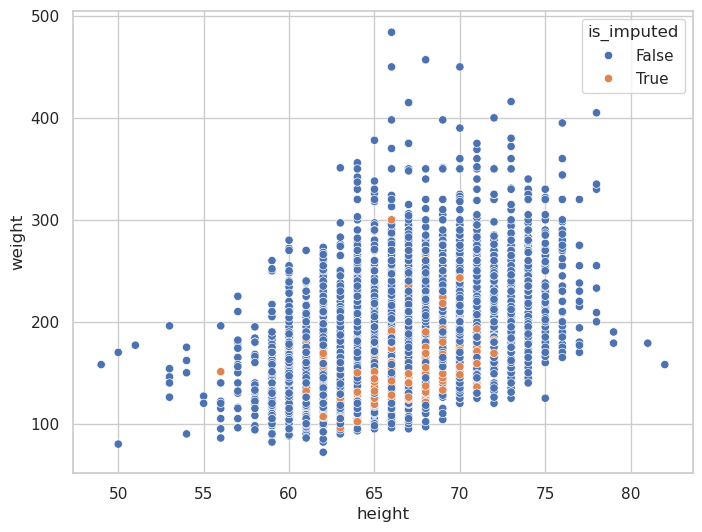

In [140]:
(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True, False, suffix='_imp', only_missing=True)
        ],
        axis = 1
    )
    .missing.scatter_imputation_plot(
        x="height",
        y='weight'
    )
)

## Imputación basada en modelos

In [156]:
nhanes_model_df = (
    nhanes_df
    .select('height', 'weight', 'gender', 'age')
    .sort_values(by='height')
    .transform_column(
        'weight',
        lambda x : x.ffill(),
        elementwise = False
    )
    .missing.bind_shadow_matrix(
        True,
        False,
        suffix = '_imp',
        only_missing = False
    )
)
nhanes_model_df

,height,weight,gender,age,height_imp,weight_imp,gender_imp,age_imp
SEQN,,,,,,,,
94940.0,49.0,158.0,Female,80.0,False,False,False,False
96508.0,50.0,170.0,Female,46.0,False,False,False,False
97877.0,50.0,80.0,Female,29.0,False,False,False,False
102379.0,51.0,177.0,Female,71.0,False,False,False,False
93816.0,53.0,146.0,Female,80.0,False,False,False,False
...,...,...,...,...,...,...,...,...
102915.0,NaN,107.0,Female,14.0,True,False,False,False
102926.0,NaN,107.0,Female,15.0,True,False,False,False
102941.0,NaN,107.0,Female,14.0,True,False,False,False


In [157]:
height_ols = (
    nhanes_model_df
    .pipe(
        lambda df : smf.ols('height ~ weight + gender + age', data = df)
    )
    .fit()
)

In [158]:
ols_imputed_values = (
    nhanes_model_df
    .pipe(
        lambda df : df[df.height.isna()]
    )
    .pipe(
        lambda df : height_ols.predict(df).round()
    )
)

ols_imputed_values

SEQN
93707.0     69.0
93719.0     64.0
93733.0     64.0
93736.0     69.0
93737.0     69.0
            ... 
102915.0    63.0
102926.0    63.0
102941.0    63.0
102945.0    68.0
102955.0    63.0
Length: 1669, dtype: float64

In [159]:
nhanes_model_df.loc[nhanes_model_df.height.isna(), ['height']] = ols_imputed_values
nhanes_model_df

,height,weight,gender,age,height_imp,weight_imp,gender_imp,age_imp
SEQN,,,,,,,,
94940.0,49.0,158.0,Female,80.0,False,False,False,False
96508.0,50.0,170.0,Female,46.0,False,False,False,False
97877.0,50.0,80.0,Female,29.0,False,False,False,False
102379.0,51.0,177.0,Female,71.0,False,False,False,False
93816.0,53.0,146.0,Female,80.0,False,False,False,False
...,...,...,...,...,...,...,...,...
102915.0,63.0,107.0,Female,14.0,True,False,False,False
102926.0,63.0,107.0,Female,15.0,True,False,False,False
102941.0,63.0,107.0,Female,14.0,True,False,False,False


<AxesSubplot:xlabel='weight', ylabel='height'>

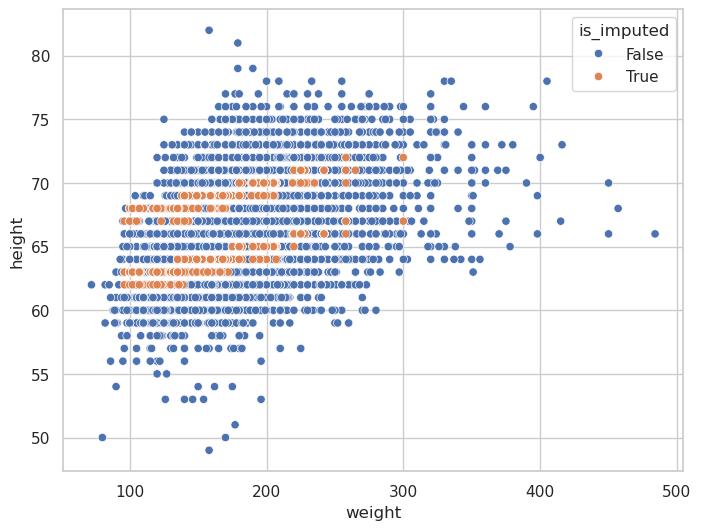

In [160]:
(
    nhanes_model_df
    .missing
    .scatter_imputation_plot(
        x = 'weight',
        y = 'height'
    )
)

## Imputaciones Múltiples por Ecuaciones Encadenadas (MICE)

<AxesSubplot:xlabel='height', ylabel='weight'>

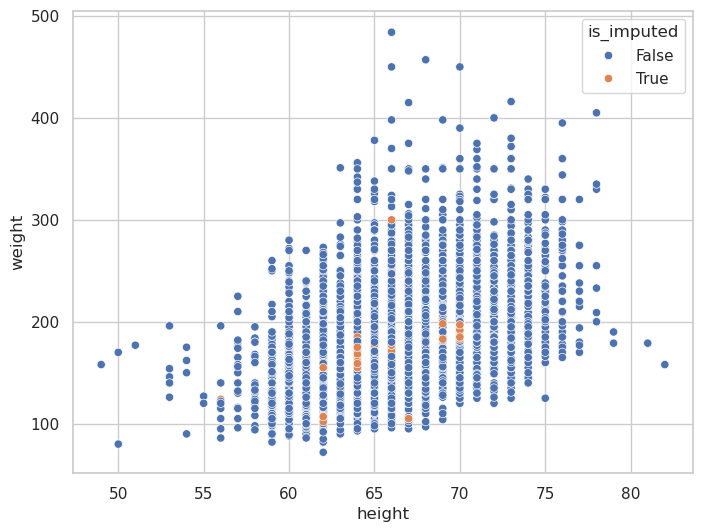

In [170]:
mice_imputer = sklearn.impute.IterativeImputer(
    estimator=BayesianRidge(),
    initial_strategy="mean",
    imputation_order='ascending'
)

nhanes_mice_df = nhanes_transformed_df.copy(deep=True)
nhanes_mice_df.iloc[:,:] = mice_imputer.fit_transform(nhanes_transformed_df).round()

nhanes_mice_df = pd.concat(
    [
        nhanes_mice_df,
        nhanes_df.missing.create_shadow_matrix(True, False, suffix='_imp')
    ],
    axis=1
)

nhanes_mice_df.missing.scatter_imputation_plot(
    x = 'height',
    y = 'weight'
)

## Transformación inversa de los datos

In [179]:
nhanes_imputed_df = nhanes_mice_df.copy(deep= True)

In [180]:
nhanes_imputed_df[categorical_columns] = (
    categorical_transformer
    .named_transformers_
    .ordinalencoder
    .inverse_transform(
        X = nhanes_mice_df[categorical_columns]
    )
)

nhanes_imputed_df

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age,height_imp,weight_imp,general_health_condition_imp,total_cholesterol_imp,pulse_imp,diabetes_imp,age_imp,gender_imp
SEQN,,,,,,,,,,,,,,,,
93705.0,Good,Female,63.0,165.0,157.0,52.0,0.0,66.0,False,False,False,False,False,False,False,False
93706.0,Very good,Male,68.0,145.0,148.0,82.0,0.0,18.0,False,False,False,False,False,False,False,False
93707.0,Good,Male,70.0,200.0,189.0,100.0,0.0,13.0,True,True,False,False,False,False,False,False
93709.0,Good,Female,62.0,200.0,176.0,74.0,0.0,75.0,False,False,True,False,False,False,False,False
93711.0,Very good,Male,69.0,142.0,238.0,62.0,0.0,56.0,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102949.0,Excellent,Male,72.0,180.0,201.0,96.0,0.0,33.0,False,False,False,False,False,False,False,False
102953.0,Fair or,Male,65.0,218.0,182.0,78.0,0.0,42.0,False,False,False,False,False,False,False,False
102954.0,Good,Female,66.0,150.0,172.0,78.0,0.0,41.0,False,False,False,False,False,False,False,False


In [181]:
nhanes_df.general_health_condition.value_counts()

general_health_condition
Good         2383
Very good    1503
Fair or      1130
Excellent     612
Poor?         169
Name: count, dtype: int64

In [182]:
nhanes_imputed_df.general_health_condition.value_counts()

general_health_condition
Good         3743
Very good    1503
Fair or      1130
Excellent     612
Poor?         169
Name: count, dtype: int64

In [184]:
nhanes_imputed_df.missing.number_missing()

0

## Continúa aprendiendo sobre el manejo de valores faltantes

<div class="alert alert-success">
    <b style="font-size: 1.5em;">✅ ¡Felicidades por terminar el curso!</b>
    <p>
    ¡Tu progreso es increíble! ¡Ahora eres capaz de llevar tus análisis al siguiente nivel! La barrera de los valores faltantes ya no es una limitante extrema para tu trabajo. Tú puedes explorar valores faltantes, eliminarlos e imputarlos siendo consciente de las ventajas y desventajas de cada método elegido. ¡Fantástico!
    </p>
    <p>
    <b>¿Cómo puedo continuar mi aprendizaje en el análisis de valores faltantes?</b>
    Poner en práctica lo aprendido es una excelente opción. Por lo tanto, te recomiendo repetir este curso utilizando la totalidad de los datos del <i>National Health and Nutrition Examination Survey</i>. Con este proyecto, serás capaz de explorar y analizar una cantidad de valores faltantes variadas. Podrás probar distintos algoritmos y estrategias. 
    </p>
    <p>
    De tal forma de que, una vez consigas tu conjunto de datos final, puedas proceder a la exploración definitiva del conjunto de datos para extraer ideas y respuestas a preguntas de tu interés. Incluso, y por qué no, podrías explorar la posibilidad de crear modelos predictivos para la diabetes. Las opciones son ilimitadas. Bienvenido al mundo de la Ciencia de Datos.
    </p>
    <p>
    Con mucha alegría por tu logro,
    Jesús Vélez Santiago
    </p>
</div>

## Información de sesión

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bdf84ff9-f66c-44c7-a67c-ca1115a2b683' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>